# uCT processing

This tutorial aids the transformation from a uCT image to a clean smooth mesh

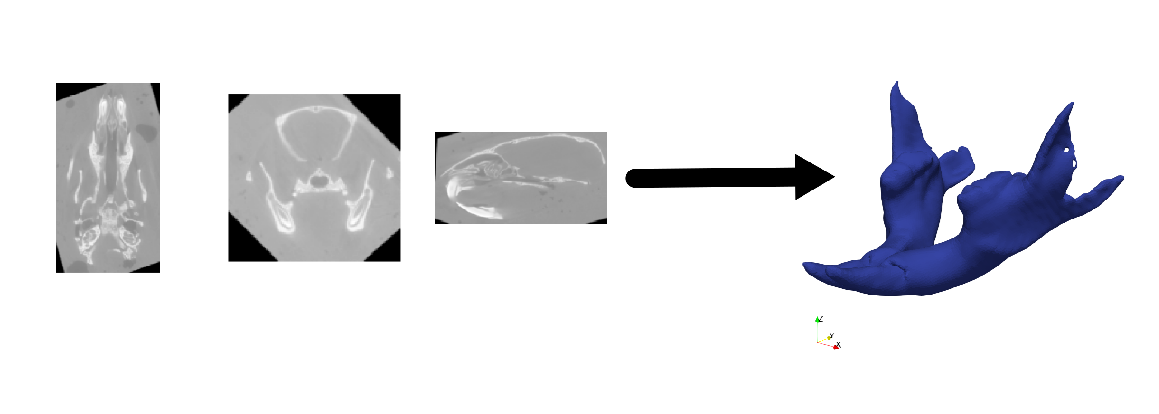

In [1]:
%matplotlib inline
import os
from matplotlib import pyplot as plt
pngfilename = os.path.join(os.getcwd(), 'Images', 'uct-process.png')
plt.figure(figsize=(20,7))
plt.imshow(plt.imread(pngfilename))
plt.axis('off')
plt.show()

The tutorial uses the data included in the subdirectory **data**.

## Python Packages required:

- matplotlib

- numpy

- SimpleITK

- vtk


## Additional Software Required:

- [FSL](https://fsl.fmrib.ox.ac.uk): required to perform simple morphological image operations and clustering


## Recommended Optional software

- [meshalb](http://www.meshlab.net): Useful to manipulate a mesh object (esp. for mesh decimation)

- [itksnap](http://www.itksnap.org): Useful to manipulate images and binary segmentations

- [paraview](https://www.paraview.org/): Useful to simply visualise mesh objects






### Binary Segmentation

Object of interest in the image is contain in the bone structure, therefore a binary threshold operation is required to extract the segmentation

This is achieved using [FSL](https://fsl.fmrib.ox.ac.uk). 



In [2]:
def which(program):
    ''' Search for a program on disk
    '''
    import os
    def is_exe(fpath):
        return os.path.isfile(fpath) and os.access(fpath, os.X_OK)

    fpath, fname = os.path.split(program)
    if fpath:
        if is_exe(program):
            return program
    else:
        for path in os.environ["PATH"].split(os.pathsep):
            exe_file = os.path.join(path, program)
            if is_exe(exe_file):
                return exe_file

    return None


def extract_major_object(filename, outputfilename, threshold=10000, closing_kernel=4, opening_kernel=4):
    ''' Extract the binary segmentation from an image using FSL
    
    The method uses FSL to perform binary thresholding, followed by boolean opening and closing operations 
    in order to extract the major object in an image. Connected components is used to remove small objects.    
    Finally, a hole-filling operation is performed. The output is written in a temporary folder and should be copied 
    somwhere else for safe keeping.
    
    @arg filename: nifti-compatible initial image
    @arg threshold: value to use for binary thresholding
    @arg closing_kernel: Kernel size to use for the closing operation, in voxel
    @arg opening_kernel: Kernel size to use for the opening operation, in voxel

    @return the output nifti file containing the binary segmentation
    '''

    import tempfile
    import os
    import shutil
    import numpy as np
    if which('fslmaths') is None:
        if which('fsl5.0-fslmaths') is not None:
            print('FSL error: Please use the global binary names. e.g. fslmaths instead of fsl5.0-fslmaths')
            return None
        print('FSL error: Please install the FSL library: https://fsl.fmrib.ox.ac.uk')
        return None

    ## create temporary directory
    owd = tempfile.mkdtemp()
    ## change current directory to temp
    pwd = os.getcwd()
    os.chdir(owd)
    ## binary thresholding
    os.system('fslmaths {} -thr {} -bin bin.nii.gz'.format(filename, threshold))
    ## closing
    os.system('fslmaths bin.nii.gz -kernel boxv {} -dilM -ero closed.nii.gz'.format(closing_kernel))
    ## clustering (separate connected components)
    os.system('cluster -i closed.nii.gz -t 1 -o cluster_index.nii.gz --osize=cluster_size > cluster_info.txt')
    ## extract biggest connected component
    cluster_idx = np.loadtxt('cluster_info.txt', skiprows=1, dtype=np.int32).flatten()[0]
    os.system('fslmaths -dt int cluster_index.nii.gz -thr {} -uthr {} -bin cluster_mask.nii.gz'.format(cluster_idx, cluster_idx)) 
    # opening
    os.system('fslmaths cluster_mask.nii.gz -kernel boxv {} -ero -dilM opened.nii.gz'.format(opening_kernel))
    ## clustering (separate connected components)
    os.system('cluster -i opened.nii.gz -t 1 -o cluster_index.nii.gz --osize=cluster_size > cluster_info.txt')
    ## extract biggest connected component
    cluster_idx = np.loadtxt('cluster_info.txt', skiprows=1, dtype=np.int32).flatten()[0]
    os.system('fslmaths -dt int cluster_index.nii.gz -thr {} -uthr {} -bin cluster_mask.nii.gz'.format(cluster_idx, cluster_idx))
    ## fill holes
    os.system('fslmaths cluster_mask.nii.gz -fillh {}'.format(outputfilename))

    ## remove temporary directory
    os.chdir(pwd)
    shutil.rmtree(owd)

    return outputfilename


## Parcellation

Parcellation of an image using SimpleITK and Watershed

In [3]:


def parcellate_object(object_image_filename, output_parcellation_filename, original_image_filename=None, 
                      watershedlevel=0.22, shrink=1):
    ''' Separate and Extract regions from a binary image, using SimpleITK

    Using a Watershed approach, this method will separate a binary mask into subregions, and order them 
    using the original image value

    @arg object_filename: binary image file
    @output_parcellation_filename: output parcellation image file name
    @arg original_image_filename: original grey value image file (used for ordering regions)
    @arg watershedlevel: Level for the watershed (use .22 for full resolution image)
    @arg shrink: Shrinking factor to increase speed (use factor 2 for full resolution image)
    @arg threshold: Threshold value for the output parcellation

    @ret: output_parcellation_filename
    '''

    import SimpleITK as sitk
    import numpy as np

    ## Read image (binary object)
    mask = sitk.ReadImage(object_image_filename, sitk.sitkUInt8)
    ## shrinking factors for speed
    factors = [shrink] * mask.GetDimension()
    ## Shrinking mask image with factor=shrink
    shrunkmask = sitk.Shrink(mask, factors)
    ## Invert mask image
    invertmask = sitk.InvertIntensity(shrunkmask)
    ## rescale mask intensities
    invertmask = sitk.RescaleIntensity(invertmask)
    ## Calculate distance map
    distances = sitk.DanielssonDistanceMap(invertmask, inputIsBinary=True, useImageSpacing=True)
    max_distance = float(np.max(sitk.GetArrayFromImage(distances)))
    ## Invert distance map
    inverteddistances = sitk.InvertIntensity(distances, maximum=max_distance)
    ## Perform the watershed algorithm
    watershed = sitk.MorphologicalWatershed(inverteddistances, level=watershedlevel, markWatershedLine=False, fullyConnected=True)
    ## Mask the watershed result with the initial mask
    watershed = sitk.Mask(watershed, shrunkmask)
    ## Resample the parcellation to original size
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(mask)
    resample.SetInterpolator(sitk.sitkNearestNeighbor)
    parcellation = resample.Execute(watershed)
    ## Write the resulting parcellation file
    sitk.WriteImage(parcellation, output_parcellation_filename)

    return output_parcellation_filename


def select_object(parcellation_filename, output_object_filename, 
                  l_threshold=0, u_threshold=255):
    ''' Separate and Extract regions from a binary image, using SimpleITK

    Using a Watershed approach, this method will separate a binary mask into subregions, and order them 
    using the original image value

    @arg object_filename: binary image file
    @output_parcellation_filename: output parcellation image file name
    @arg original_image_filename: original grey value image file (used for ordering regions)
    @arg watershedlevel: Level for the watershed (use .22 for full resolution image)
    @arg shrink: Shrinking factor to increase speed (use factor 2 for full resolution image)
    @arg threshold: Threshold value for the output parcellation

    @ret: output_parcellation_filename
    '''

    import SimpleITK as sitk
    import numpy as np

    ## Read image (binary object)
    parcellation = sitk.ReadImage(parcellation_filename, sitk.sitkUInt8)

    ## Threshold to the user defined value
    objectimage = sitk.Threshold(parcellation, lower=l_threshold, upper=u_threshold)
    objectimage = sitk.BinaryThreshold(objectimage, lowerThreshold=1.0, upperThreshold=255.0, insideValue=1, outsideValue=0)
    ## Write the resulting parcellation file
    sitk.WriteImage(objectimage, output_object_filename)

    return output_object_filename



## Mesh extraction

mesh extraction from a binary image using Marching cubes and VTK

In [4]:

def extract_mesh(parcellation_file, output_mesh_file, smooth_NIter=20, smooth_relaxation=0.6):
    ''' Extract a mesh from a binary image using vtk
    
    The method uses Marching Cubes in order to extract a mesh outlining a binary segmentation image
    The mesh is then smoothed in order to avoid the pixelization effect
    
    @arg parcellation_file: input binary image file
    @arg output_mesh_file: output vtk mesh file
    @arg smooth_NIter: number of iterations for the smoothing filter
    @arg smooth_relaxation: Relaxation factor for the smoothing filter
    
    @ret: output_mesh_file
    '''

    import vtk

    ## read the input binary image
    reader = vtk.vtkMetaImageReader()
    reader.SetFileName(parcellation_file)
    reader.Update()
    ## perform marching cubes
    mc = vtk.vtkImageMarchingCubes()
    mc.SetInputConnection (reader.GetOutputPort())
    mc.ComputeNormalsOff()
    mc.ComputeGradientsOff()
    mc.ComputeScalarsOn()
    mc.SetValue(0, 0)
    ## smooth the output mesh
    smoother = vtk.vtkSmoothPolyDataFilter()
    smoother.SetInputConnection(mc.GetOutputPort())
    smoother.SetNumberOfIterations(smooth_NIter)
    smoother.SetRelaxationFactor(smooth_relaxation)
    smoother.FeatureEdgeSmoothingOff()
    smoother.BoundarySmoothingOn()
    ## write the output to file
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(output_mesh_file)
    writer.SetInputConnection(smoother.GetOutputPort())
    writer.Write()

    return output_mesh_file



## Mirror mesh file

Method to mirror a vtk mesh in a particular direction

The mesh point vectors $d$ are mirrored using the normal vector $n$, producing vectors $r$ as follows:

$r = d - 2 \left(d \cdot n \right) n$

In [5]:

def mirror_mesh(input_mesh_file, output_mesh_file, mirror_direction=[0,0,1]):
    ''' Mirror a mesh in a specific direction
    
    The method will mirror a mesh position vectors using the surface normal `mirror_direction`:
    
    $r = d - 2 \left(d \cdot n \right) n$
    
    @arg input_mesh_file: input vtk mesh file
    @arg output_mesh_file: output vtk mesh file
    @arg mirror_direction: normalised mirror direction vector
    
    @ret: output_mesh_file
    '''

    import vtk
    import numpy as np
    
    ## read the input binary image
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(input_mesh_file)
    reader.Update()

    mesh = reader.GetOutput()
    points = mesh.GetPoints()

    for idx in range(mesh.GetNumberOfPoints()):
        pt_in = points.GetPoint(idx)
        pt_out = np.array(pt_in) - 2. * np.dot(pt_in, mirror_direction) * np.array(mirror_direction)
        points.SetPoint(idx, pt_out)    

    ## write the output to file
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(output_mesh_file)
    writer.SetInputData(mesh)
    writer.Write()

    return output_mesh_file



## Display help functions

In [6]:

def display_mesh(vtkfile, pngfilename, w=600, h=600):
    ''' Display a mesh using vtk and matplotlib
    '''

    import vtk
    from matplotlib import pyplot as plt

    ## read the input vtk mesh
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(vtkfile)
    ## vtk rendering pipeline
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(reader.GetOutputPort())
    mapper.SetScalarVisibility(0)
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor(0.5, 0.5, 1.0)
    ren = vtk.vtkRenderer()
    ren.AddActor(actor)
    ren.SetBackground(1, 1, 1)
    ren.ResetCamera()
    ## render window with offscreen rendering
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(ren)
    renderWindow.SetSize(w, h)
    renderWindow.Render()
    ## render window to image
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()     
    ## writing screenshot to file
    writer = vtk.vtkPNGWriter()
    writer.SetFileName(pngfilename)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    ## display the screenshot
    plt.figure(figsize=(10,10))
    plt.imshow(plt.imread(pngfilename))
    plt.axis('off')
    plt.show()

    return pngfilename


def display_image(filename):
    ''' Display an image using SimpleITK and matplotlib
    '''
    import SimpleITK as sitk
    from matplotlib import pyplot as plt
    import numpy as np
    import math
    
    im = sitk.ReadImage(filename)
    half_size = [int(math.floor(im.GetSize()[i]/2.0)) for i in range(im.GetDimension())]

    arr = sitk.GetArrayFromImage(im)
    arr = np.flip(arr, 0)
    plt.figure(figsize=(5*im.GetDimension(),5))    

    for d in range(im.GetDimension()):
        plt.subplot(1, im.GetDimension(), d+1)
        if d == 0:
            img = arr[half_size[d],:,:]
        elif d == 1:
            img = arr[:,half_size[d],:]
        elif d == 2:
            img = arr[:,:, half_size[d]]
        aspect=(im.GetSpacing()[np.mod(d+1,3)] * im.GetSize()[np.mod(d+1,3)])/(im.GetSpacing()[np.mod(d+2,3)] * im.GetSize()[np.mod(d+2,3)])
        aspect=np.power(aspect, 1./20.)
        plt.imshow(img,cmap=plt.cm.Greys_r,aspect=aspect);
        plt.axis('off')

    plt.show()

    return arr


## Generic Imports

In [7]:
%matplotlib inline
import os
from matplotlib import pyplot as plt
import numpy as np

## Loading data

In this tutorial the input data is locally installed in the subdirectory **data**.

The variable **input_image** is a uCT of a mouse cranium. See below for display and histogram. Feel free to change that variable to try out a new input image.

The variable **working_directory** is where the output and intermediate data will be stored. Feel free to change that too.


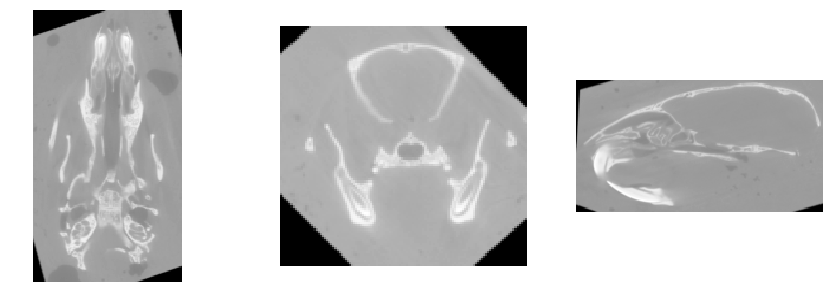

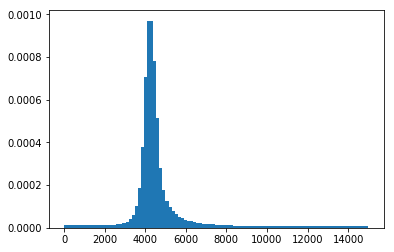

In [8]:
working_directory = os.path.join(os.getcwd(), 'data', 'preprocessing')
input_image = os.path.join(os.getcwd(), 'data', 'uCT-1.nii.gz')
arr = display_image(input_image)
_ = plt.hist(arr.flatten(), np.linspace(0,15000,100), density=True)

## Object Extraction

We intend to extract the object of interest from the image in the form of a binary segmentation. This is achieved by thresholding the image with an appropriate value (in this case ~10'000). This is followed by morphological closing and opening, and extracting the largest connected component. 
> tip: Use [itksnap](http://www.itksnap.org) on **region_file** (open as a *segmentation*, with the main image being **input_image**) to manually modify the extracted region segmentation (i.e. fill holes)

> Change the parameter **threshold** in order to focus on the object of interest

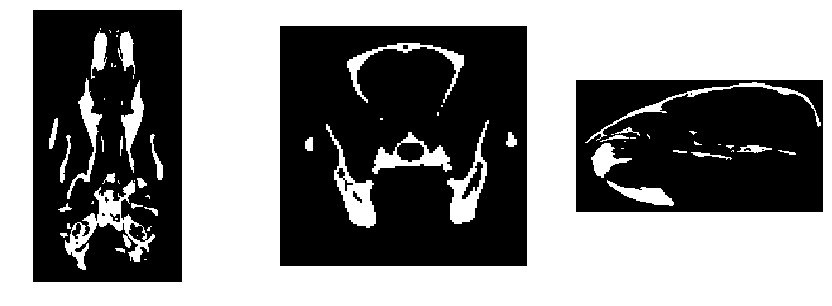

In [9]:

object_file = extract_major_object(input_image, 
                                   os.path.join(working_directory, 'uCT-1_object.nii.gz'),
                                   threshold=9000, 
                                   closing_kernel=1, 
                                   opening_kernel=0)
arr = display_image(object_file)

## Region Parcellation 

This binary segmentation can then be parcellated in order to extract a particular sub-region that we are interested in. This is achieved using a Danielsson distance map calculation followed by a Watershed parcellation filter.

Be mindful of the parameters **watershedlevel** (controls the greedyness of the parcellation) and **shrink** (which is useful for speeding up the procedure but should not be used when the image is of low resolution)


> tip: Use [itksnap](http://www.itksnap.org) on **region_file** (open as a *segmentation*, with the main image being **input_image**) to check what label corresponds to the object that concerns you.


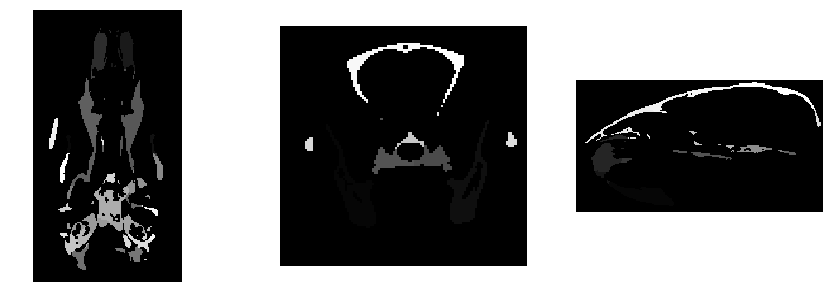

In [10]:
region_file = parcellate_object(object_file,
                                os.path.join(working_directory, 'uCT-1_regions.mha'), 
                                watershedlevel=.1,
                                shrink=1)

arr = display_image(region_file)

## Object Selection



The parameter **threshold** can be used to extract the particular region of interest. The regions should be ordered by the mean value they provide in the original image. 

In this example, we can extract each mandible by selecting the thresholds to respectively **1** and **2**. Or have both mandibles using thresholds **1** and **2**. We can also select the entire cranium using the default thresold values **1** and **255***

> tip: Use [itksnap](http://www.itksnap.org) on **selectedobject_file** (open as a *segmentation*, with the main image being **input_image**) to manually modify the extracted region segmentation (i.e. fill holes, remove foreign objects)


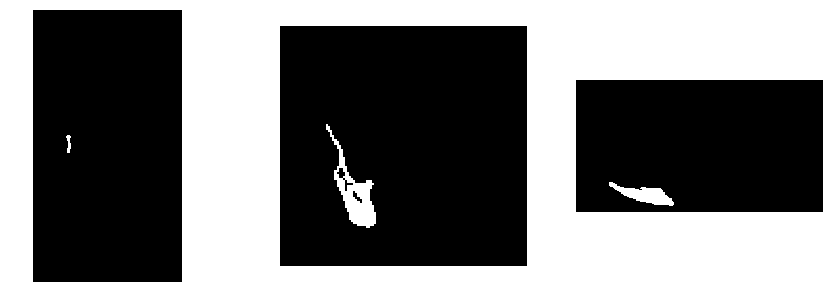

In [11]:
selectedobject_file = select_object(region_file,
                                    os.path.join(working_directory, 'uCT-1_selectedobject.mha'), 
                                    l_threshold=1,
                                    u_threshold=1)
arr = display_image(selectedobject_file)

## Extract Mesh

Now that we have isolated our region we can extract the mesh surrounding the binary mask using marching cubes.
The mesh is smoothed using the parameter **smooth_relaxation**. Suggested value is **smooth_relaxation=.66** for a full resolution uCT image. Here we use **smooth_relaxation=.2**.

> **tip**: You can change the output mesh file to a desired location

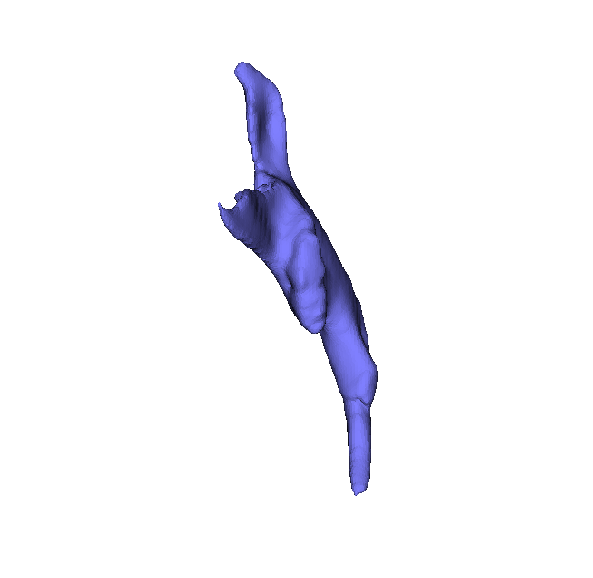

In [12]:
mesh_file = extract_mesh(selectedobject_file,
                         os.path.join(working_directory, 'uCT-1_regions.vtk'),
                         smooth_relaxation=.2)
png_file = display_mesh(mesh_file, 
                        os.path.join(working_directory, 'uCT-1_regions.png'))

In this particular example the mandibles were correctly separated. 

But you will need to change some of the parameters if that is not the case for your specific application/input image

> **tip**: You can visualise the vtk object easily using [paraview](https://www.paraview.org/)

> **tip**: You can easily decimate the high resolution mesh by (1) opening the vtk file in paraview, saving it as an .stl file; (2) use [meshalb](http://www.meshlab.net) decimation tool, e.g. **Quadratic Edge Collapse Decimation**) to your convenience. Save the decimated file an as .VTK using paraview and ensure it saves as an ASCII. Here is the result of a adequately decimated mesh:

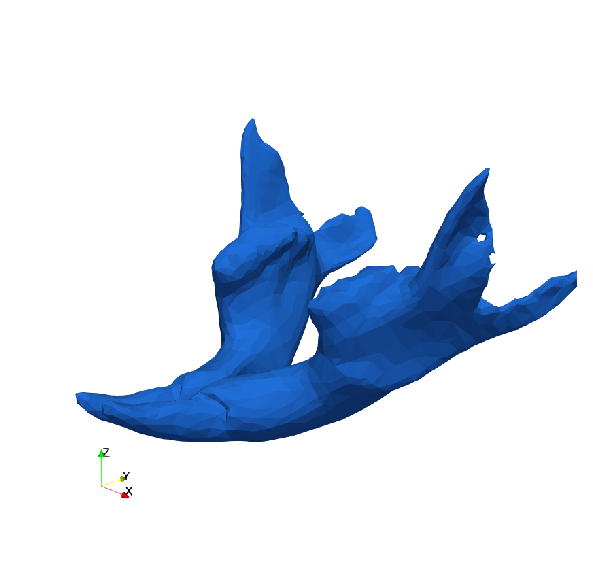

In [13]:
%matplotlib inline
import os
from matplotlib import pyplot as plt
pngfilename = os.path.join(os.getcwd(), 'Images', 'decimated-mesh.png')
plt.figure(figsize=(10,10))
plt.imshow(plt.imread(pngfilename))
plt.axis('off')
plt.show()

## Mirror the mesh file if necessary

Sometimes it is of intertrest to mirror the mesh as a data augmentation technique

In this case we want to mirror the right mandible in the x-direction in order to obtain a **second** left mandible

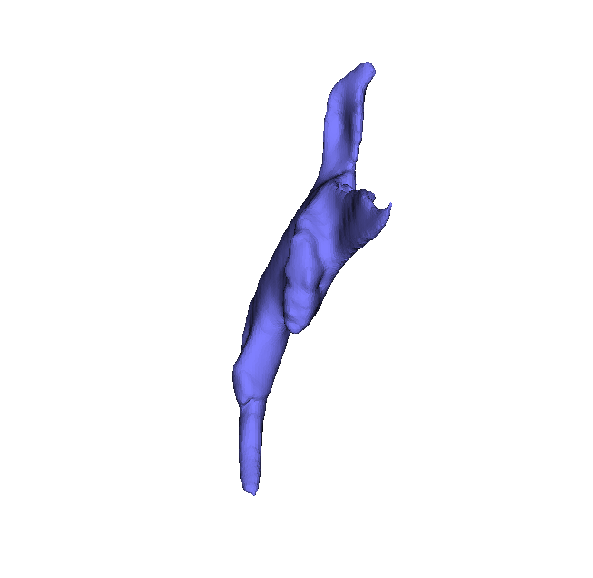

In [14]:
mirror_mesh_file = mirror_mesh(mesh_file, os.path.join(working_directory, 'uCT-1_regions_m.vtk'), 
                               [1,0,0])

png_file = display_mesh(mirror_mesh_file, 
                        os.path.join(working_directory, 'uCT-1_regions_m.png'))

## Scalability

If you need to repeat that operation a number of times for a list of input images, use the following code, replacing **input_images** by the ones you need to process:

---

```python

import os
from glob import glob

working_directory = os.path.join(os.getcwd(), 'data')

extension='.nii.gz'
input_images = glob('{}{}*{}'.format(working_directory, os.sep, extension))

for input_image in input_images:
    fn, _ = os.path.basename(input_image).split(extension)
    object_file = extract_major_object(input_image, 
                                       os.path.join(working_directory, '{}_object.nii.gz'.format(fn)),
                                       threshold=9000, 
                                       closing_kernel=1, 
                                       opening_kernel=0)
    region_file = parcellate_object(object_file,
                                    os.path.join(working_directory, '{}_regions.mha'.format(fn)), 
                                    watershedlevel=.1,
                                    shrink=1,
                                    l_threshold=1,
                                    u_threshold=2)
    mesh_file = extract_mesh(region_file,
                             os.path.join(working_directory, '{}_regions.vtk'.format(fn)),
                             smooth_relaxation=.2)


```

---



## About this notebook

written by Nicolas Toussaint

Contact: <nicolas.a.toussaint@kcl.ac.uk>